

Choosing a model for temporary market impact, $g_t(x)$, is critical for any effective order execution system. A simple linear model, $g_t(x)=beta_tx$, is a significant oversimplification. It incorrectly assumes that each share in an order has the same marginal cost. This is not how it works. The structure of a limit order book, with its discrete price levels and finite liquidity, means that larger orders must go through multiple levels in the order book consuming liquidity at progressively worse prices. This results in a non-linear concave impact function where impact grows more slowly than order size.

Analysis of the three tickers(SOUN,FROG,CRWV) demonstrates that no single fixed formula can reliably model market impact across different stocks. The best approach is an empirical journey, starting with simple models and progressing to more powerful, data driven methods.

# Square Root Model and Its Limitations
A strong theoretical starting point is the Square Root Impact Model, g_t(x)=
sigma_t*sqrt(x).However, when validated against the three tickers, its limitations became clear, as measured by the R-squared value


* SOUN(High-Liquidity): The model failed completely. The analysis showed consistently negative R-squared values, meaning its predictions were worse than a simple average.
* FROG(Medium-Liquidity): The model was inconsistent. It achieved a positive average R-squared of 0.21 but the fit was highly volatile.


* CRWV (Illiquid): The model was unreliable, with a volatile fit and an average R-squared of approximately 0.33.

While a Piecewise Model offers an improvement by penalizing large orders more heavily, it still relies on the rigid square root assumption.






# The Superior Solution: A Gradient Boosting Model
This machine learning model learns the complex patterns of market impact directly from the data without being confined to a fixed formula.ts superiority was demonstrated by its exceptional performance across all three stocks when using all 10 levels of order book data as features:


*   $SOUN: R^2 = 0.9923$
*   $FROG: R^2= 0.9813$


*   $CRWV: R^2= 0.8816$

The Gradient Boosting model succeeded because it leverages a rich set of features including the spread, liquidity imbalance, and the depth of the entire order book to make highly accurate, context aware predictions for each specific stock.






In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)


--- Running Full Analysis for: --- /content/CRWV_2025-04-03 00:00:00+00:00.csv
Generating features from 5000 snapshots...


100%|██████████| 5000/5000 [00:09<00:00, 546.47it/s]



Training Gradient Boosting model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10393
[LightGBM] [Info] Number of data points in the train set: 22122, number of used features: 43
[LightGBM] [Info] Start training from score 0.002150
Evaluating model performance...

--- Model Evaluation Results ---
R-squared (R²): 0.8877
Mean Absolute Error (MAE): 0.000450
Conclusion: The Gradient Boosting model is a strong fit and highly predictive.


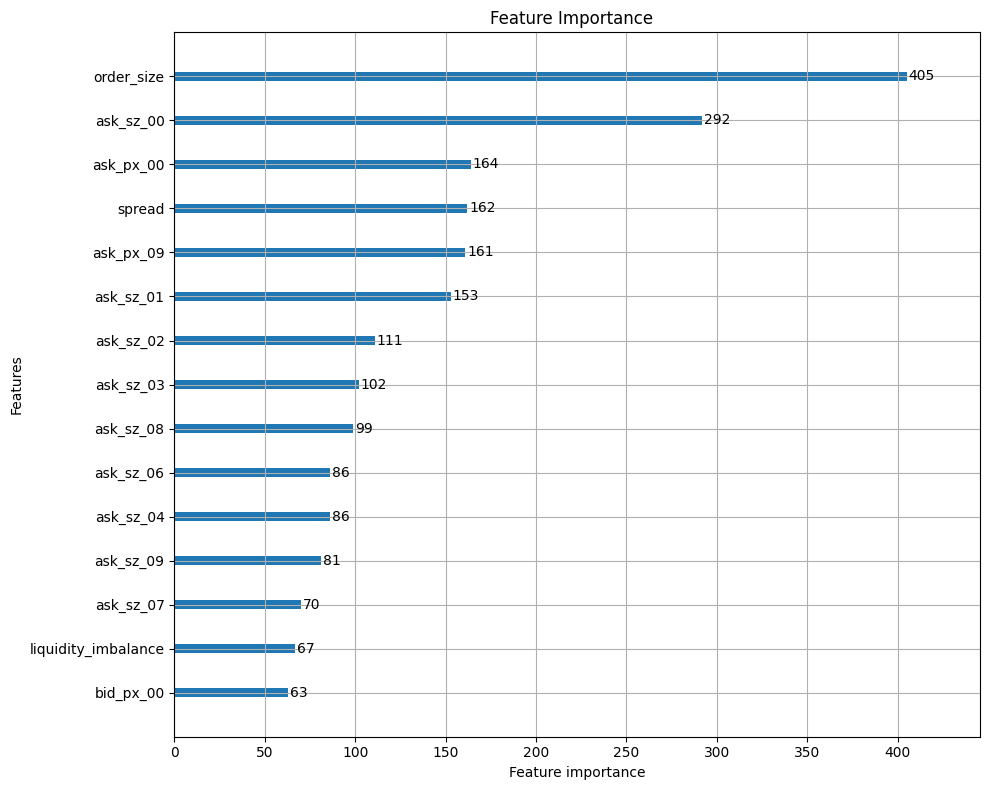


--- Running Full Analysis for: --- /content/FROG_2025-04-03 00:00:00+00:00.csv
Generating features from 5000 snapshots...


100%|██████████| 5000/5000 [00:07<00:00, 665.17it/s]



Training Gradient Boosting model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6238
[LightGBM] [Info] Number of data points in the train set: 19730, number of used features: 43
[LightGBM] [Info] Start training from score 0.001752
Evaluating model performance...

--- Model Evaluation Results ---
R-squared (R²): 0.9732
Mean Absolute Error (MAE): 0.000139
Conclusion: The Gradient Boosting model is a strong fit and highly predictive.


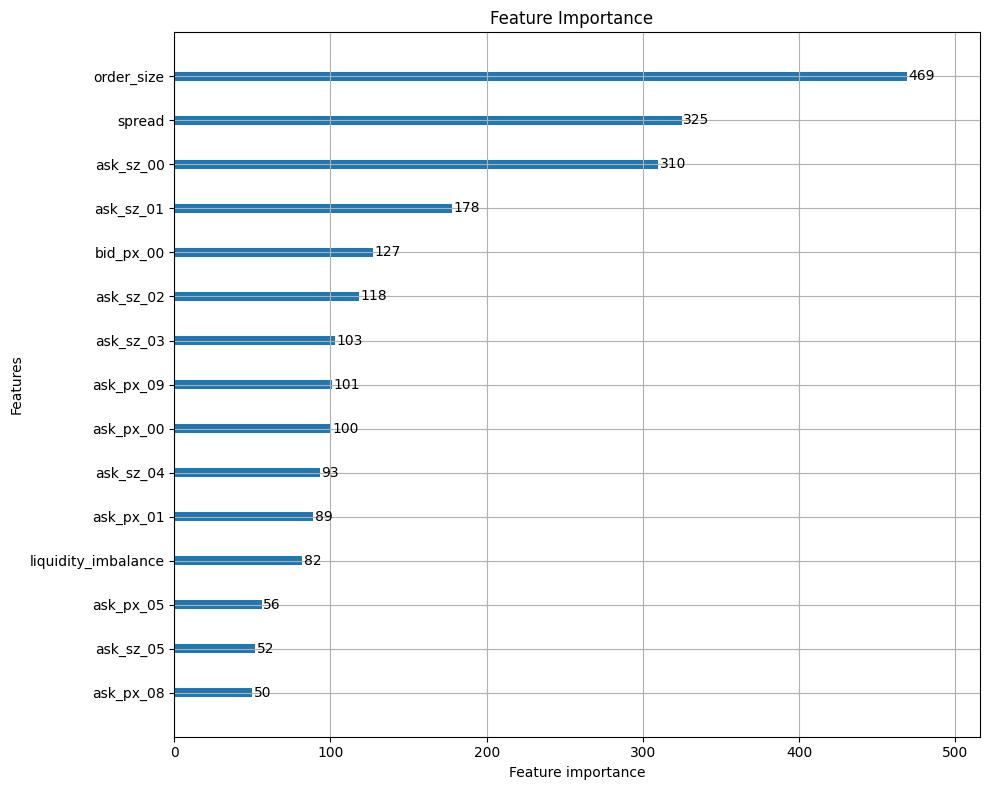


--- Running Full Analysis for: --- /content/SOUN_2025-04-03 00:00:00+00:00.csv
Generating features from 5000 snapshots...


100%|██████████| 5000/5000 [00:09<00:00, 516.45it/s]



Training Gradient Boosting model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6522
[LightGBM] [Info] Number of data points in the train set: 32021, number of used features: 43
[LightGBM] [Info] Start training from score 0.001072
Evaluating model performance...

--- Model Evaluation Results ---
R-squared (R²): 0.9926
Mean Absolute Error (MAE): 0.000018
Conclusion: The Gradient Boosting model is a strong fit and highly predictive.


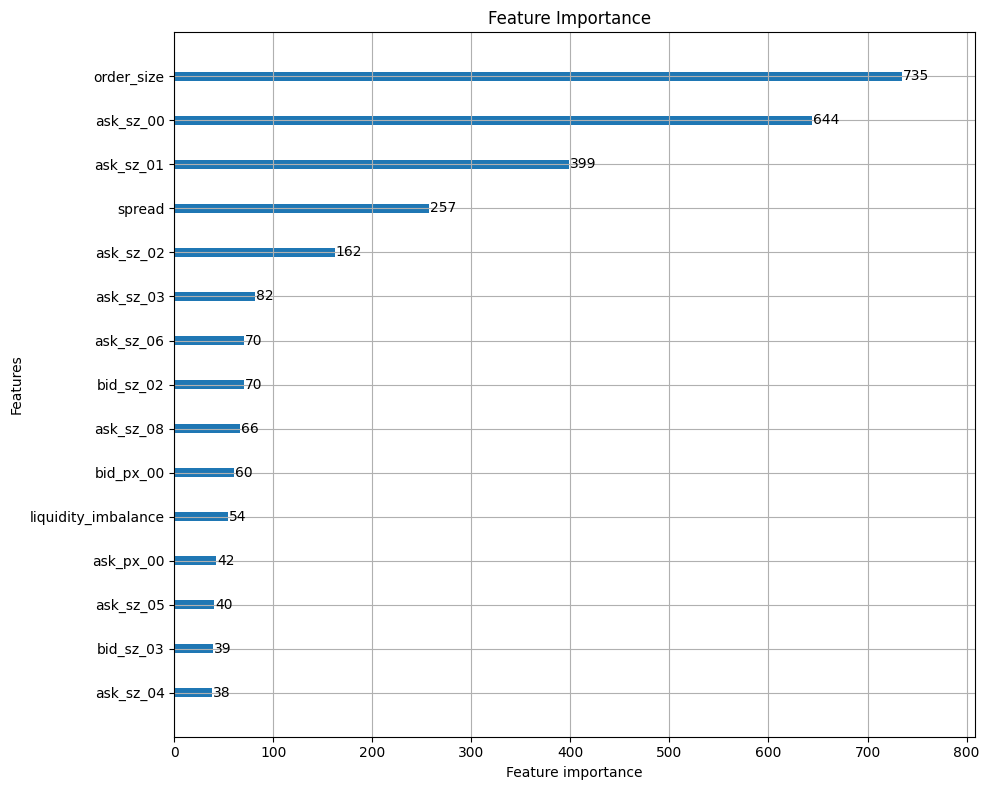

In [ ]:


def calculate_true_impact(row, order_size):

    mid_price = (row['bid_px_00'] + row['ask_px_00']) / 2
    if pd.isna(mid_price): return np.nan

    remaining, total_cost, filled = order_size, 0.0, 0
    for i in range(10):
        price, size = row.get(f'ask_px_{i:02d}'), row.get(f'ask_sz_{i:02d}')
        if pd.isna(price) or pd.isna(size) or size == 0: continue

        fill_size = min(remaining, size)
        total_cost += fill_size * price
        remaining -= fill_size
        filled += fill_size
        if remaining == 0: break

    if remaining > 0 or filled == 0: return np.nan
    return (total_cost / filled - mid_price) / mid_price

def create_feature_dataset(df, num_snapshots=5000, test_sizes=None):

    if test_sizes is None:
        test_sizes = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 100000]

    features_list = []
    sample_indices = np.random.choice(len(df), min(num_snapshots, len(df)), replace=False)

    print(f"Generating features from {len(sample_indices)} snapshots...")
    for idx in tqdm(sample_indices):
        row = df.iloc[idx]
        for size in test_sizes:
            impact = calculate_true_impact(row, size)
            if pd.isna(impact): continue

            features = {'order_size': size, 'target_impact': impact}
            features['spread'] = row['ask_px_00'] - row['bid_px_00']

            ask_liquidity = sum(row.get(f'ask_sz_{i:02d}', 0) for i in range(10))
            bid_liquidity = sum(row.get(f'bid_sz_{i:02d}', 0) for i in range(10))
            features['liquidity_imbalance'] = (bid_liquidity - ask_liquidity) / (bid_liquidity + ask_liquidity + 1e-9)

            # Use all 10 levels of the book for features
            for i in range(10):
                features[f'ask_px_{i:02d}'] = row[f'ask_px_{i:02d}']
                features[f'ask_sz_{i:02d}'] = row[f'ask_sz_{i:02d}']
                features[f'bid_px_{i:02d}'] = row[f'bid_px_{i:02d}']
                features[f'bid_sz_{i:02d}'] = row[f'bid_sz_{i:02d}']

            features_list.append(features)

    return pd.DataFrame(features_list)

def run_gradient_boosting_analysis(file_path):

    print(f"\n--- Running Full Analysis for: ---",file_path)
    df = pd.read_csv(file_path).dropna()

    # 1. Create the dataset for training
    feature_df = create_feature_dataset(df)

    if feature_df.empty or len(feature_df) < 100:
        print("Could not generate a sufficient feature dataset. Skipping.")
        return

    # 2. Split data for training and testing
    X = feature_df.drop('target_impact', axis=1)
    y = feature_df['target_impact']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Train the Gradient Boosting Model (LightGBM)
    print("\nTraining Gradient Boosting model...")
    lgbm = lgb.LGBMRegressor(random_state=22)
    lgbm.fit(X_train, y_train)

    # 4. Evaluate the model
    print("Evaluating model performance...")
    y_pred = lgbm.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print("\n--- Model Evaluation Results ---")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    if r2 > 0.8:
        print("Conclusion: The Gradient Boosting model is a strong fit and highly predictive.")
    else:
        print("Conclusion: The model has some predictive power, but could be improved.")

    # 5. Plot Feature Importance
    lgb.plot_importance(lgbm, figsize=(10, 8), max_num_features=15)
    plt.title(f'Feature Importance  ')
    plt.tight_layout()
    plt.show()




ticker_files = [
        '/content/CRWV_2025-04-03 00:00:00+00:00.csv',
        '/content/FROG_2025-04-03 00:00:00+00:00.csv',
        '/content/SOUN_2025-04-03 00:00:00+00:00.csv'
    ]

    # Run the analysis for each file
for file in ticker_files:
        run_gradient_boosting_analysis(file)



 The goal is to execute a total of S shares over N discrete trading periods (390 one minute intervals) in a way that minimizes the total cost from temporary market impact. We need to find an allocation vector X that defines the number of shares to trade in each period i.
The total cost, C(X), is the sum of the costs of each individual trade. The cost of a single trade is its size multiplied by its impact.the most accurate impact forecast is provided by our trained Gradient Boosting Model, GBM_predict. This model serves as our cost function.

$\min_{C(X)} = \sum_{i=1}^{N} \text{Cost}_i(x_i) = \sum_{i=1}^{N} x_i \cdot \text{GBM\_predict}(\text{features}_i, x_i)$

Gradient Boosting model is not interpretable we cannot use simple calculus to find the perfect answer all at once. Instead, we use a smart, step by step algorithm that makes good decisions in real time.algorithm works by intelligently adjusting its trading speed based on historic conditions which the model should be trained. At any given moment, it knows the simple average number of shares it needs to trade per minute to finish the order on time the baseline rate(S/N). It then uses the trained ML model to predict the cost of trading right now. If the model predicts that the current impact is lower than the day's average (meaning it's a cheap time to trade), it will trade more than the baseline rate. Conversely, if the model predicts a high impact (an expensive time), it will trade less, saving shares to execute later when conditions might be better. This simple logic of buy more when it's cheap, less when it's expensive allows the algorithm to naturally reduce costs, while safety checks ensure the full order is completed by the end of the day.
